In [124]:
%load_ext autoreload
%autoreload 2
import os, json, re, sys, time, warnings, datetime
from html import unescape
#sys.path.insert(0, '../scattertext/')
import spacy
import pandas as pd
import numpy as np
import scattertext as st
import agefromname
from tqdm.notebook import tqdm
from IPython.core.display import HTML, display
from IPython.display import IFrame
display(HTML("<style>.container { width:98% !important; }</style>"))

tqdm.pandas()

warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
assert st.version >= [0, 1, 3]

## Initial Data Collection

- Use snscrape to download 50k tweets mentioning "moderna" and 50k mentioning "pfizer"
- Start date: May 1, 2021
- Filter out tweets only containing links and mentions
- The first row of the collected data frame is outputted
- After the first round of filtering, we end up with just under 50k tweets per query

In [126]:
#This will takes me 20-30 minutes to download from my home internet connection
# If you do download, ensure snscrape is installed using: 
# source activate idt && pip install -U git+https://github.com/JustAnotherArchivist/snscrape.git
virtual_env = 'idt'
queries = ["moderna", "pfizer"]
max_results = 50000
since_date = "2021-05-01"

# set to false to ensure if you don't want to scrape data when the cell is run
scrape_data, make_csv = False, False 

for query in queries:
    results_file_name = f"{query}-{since_date}-{max_results}.json"

    if scrape_data:
        os.system(f'source activate idt && snscrape --jsonl --progress --max-results {max_results} '
                  f'--since {since_date} twitter-search "{query}" > {results_file_name}')
    if make_csv:
        data = []
        for text in tqdm(line.strip() for line in open(results_file_name) if line.strip()):
            data.append(json.loads(text.encode('ascii', 'ignore').decode('utf-8')))

        pd.DataFrame(data).assign(
            Text = lambda df: df.content.apply(
                lambda text: ' '.join(
                    word for word in text.split() 
                    if not (word.startswith('@') or word.startswith('http')))
            )
        )[
            lambda df: df.Text.str.len() > 0
        ].to_csv(results_file_name + '.csv', index=False)
        
df = pd.concat([
    pd.read_csv(
        f"{query}-{since_date}-{max_results}.json.csv.gz", 
        index_col=None, header=0, engine='python', compression='gzip'
    ).assign(Query=query)
    for query in queries
]).reset_index(drop=True)
df.iloc[0]

url                https://twitter.com/augusfraschina/status/1390...
date                                       2021-05-07T01:35:52+00:00
content            @LANACION Jajajajaa las pelotudeces de la soci...
renderedContent    @LANACION Jajajajaa las pelotudeces de la soci...
id                                               1390480471692390401
user               {'username': 'augusfraschina', 'displayname': ...
outlinks                                                          []
tcooutlinks                                                       []
replyCount                                                       0.0
retweetCount                                                     0.0
likeCount                                                          0
quoteCount                                                         0
conversationId                                   1390478189563162633
lang                                                              es
source             <a href="http:/

In [127]:
df.Query.value_counts()

moderna    49912
pfizer     49835
Name: Query, dtype: int64

### User gender prediction
- Use the `AgeFromName` to collect a data frame of first names given to babies born in the US who, as of 2021, are between 18 and 60 years old.
 - A stab at the age range of most people tweeting.
 - Contains the probability from the Social Security Administration a person that age rage who has the name was asigned female at birth
 - Denote `F` as likely assigned female at birth, `M` as likely assigned male at birth, and `Ind` as indeterminate
  - 95% confidence interval, and the mean probability.
   - P(`F`|Pat) $\in$ $[0.283809, 0.293993]_{95\%}$
   - P(`F`|Shannon) $\in$ $[0.859481, 0.861918]_{95\%}$
  - "Likely" indicates the high-end confidence interval is $<0.07$ or the low-end is $>0.93$.
   - Filter for English-language tweets; remove duplicate tweets
- Filter to users with an unambiguous first name gender

In [128]:
name_gender_df = (
    agefromname.AgeFromName()
    .get_all_name_female_prob(current_year=2021, minimum_age=18, maximum_age=60)
)
first_name_df = df[~pd.isna(df.user)].assign(
    DisplayName = lambda df: df.user.apply(eval).apply(
        lambda x: x['displayname'] if type(x) == dict else None
    ),
)[lambda df: ~pd.isna(df.DisplayName)].assign(
    FirstName = lambda df: df.DisplayName.apply(lambda x: x.split()[0].lower()),
).loc[lambda df: df[['Text', 'FirstName']].drop_duplicates().index]

gender_prob_threshold = 0.07
df_with_gender_prob = pd.merge(
    first_name_df,
    name_gender_df[['prob', 'lo', 'hi']],
    left_on='FirstName',
    right_index=True,
    how='inner'
).assign(
    ProbableGender = lambda df: df.apply(
        lambda x: 'M' if x.hi <= gender_prob_threshold else 'F' if x.lo >= 1-gender_prob_threshold else 'Ind',
        axis = 1
    ),
    UserName = lambda df: df.user.apply(eval).apply(lambda x: x['username'] if type(x) == dict else None)
)[
    lambda df: (df.lang == 'en') & (~df.UserName.str.startswith('CovidVaccine'))
].loc[
    lambda df: df.Text.apply(
        lambda x: ' '.join([t for t in x.lower().split() if t[0] not in ['#', '@']])
    ).drop_duplicates().index
].sort_values(by='date')


In [129]:
name_gender_df.loc['pat']

lo      0.283809
hi      0.304387
prob    0.293993
Name: pat, dtype: float64

In [130]:
name_gender_df.loc['shannon']

lo      0.859481
hi      0.861918
prob    0.860704
Name: shannon, dtype: float64

In [131]:
df_with_gender_prob[['DisplayName', 'FirstName', 'hi', 'lo', 'ProbableGender', 'Text']].iloc[5]

DisplayName                                         Phyllis De Soto
FirstName                                                   phyllis
hi                                                          0.99832
lo                                                         0.997155
ProbableGender                                                    F
Text              #creepy #vaccine In general most Americans sup...
Name: 49899, dtype: object

### Analysis of filtered data set
- A total of 19.5K tweets remain
- 48% (14K) of those are from moderna
- 51% of those tweeting are categorized as `M`
- 30% as `F`
- 19% as `Ind`


In [132]:
print('Total tweets:', len(df_with_gender_prob))
print()
print(df_with_gender_prob.assign(Cnt=1, Pct=1/len(df_with_gender_prob)).groupby('Query')['Cnt','Pct'].sum())
print()
print(df_with_gender_prob.assign(
    Cnt=1,
    Pct=1/len(df_with_gender_prob), 
).groupby('ProbableGender')['Cnt','Pct'].sum())
print()
print(df_with_gender_prob.assign(C=1).groupby(['ProbableGender', 'Query'])['C'].sum())

Total tweets: 24032

           Cnt       Pct
Query                   
moderna  14006  0.582806
pfizer   10026  0.417194

                  Cnt       Pct
ProbableGender                 
F                7255  0.301889
Ind              4494  0.187001
M               12283  0.511110

ProbableGender  Query  
F               moderna    4176
                pfizer     3079
Ind             moderna    2610
                pfizer     1884
M               moderna    7220
                pfizer     5063
Name: C, dtype: int64


### Parse remaining 
- Use a partial reimplimentation of spaCy to parse each tweet

In [133]:
df_with_gender_prob = df_with_gender_prob.assign(
    Parse = lambda df: df.Text.apply(unescape).progress_apply(st.whitespace_nlp_with_sentences)
)

### Use Scattertext to identify words associated with a query
- Use Cohen's d with a family-wise error rate correction to analyze word distributions
- Based on the `df_with_gender_prob` dasta frame
- The `category_col` argument is the column name of the target variable
- `parsed_col` the column name of the spaCy `Doc` compatiable object reprsenting the parse of each tweet
- Only consider stoplisted unigrams as independent variables
 - Remove words which occur less than 10 times, remove moderna and pfizer 
 - We are left with about 3K word types

In [134]:
corpus = st.CorpusFromParsedDocuments(
    df_with_gender_prob,
    category_col='Query',
    parsed_col='Parse'
).build(
).get_stoplisted_unigram_corpus(
)

In [135]:
corpus.get_num_terms()


21231

In [136]:
number_re = re.compile(r'\d+')
frequent_corpus = corpus.remove_terms(
    [x for x in corpus.get_terms() 
     if len(x) < 3 or x in ['moderna', 'pfizer'] or number_re.match(x) is not None]
).remove_infrequent_words(
    10
)
frequent_corpus.get_num_terms()

2739

### Terms associated with each vaccine
- We can use [Cohen's d](https://people.bath.ac.uk/pssiw/stats2/page2/page14/page14.html) to identify which of these terms more characteristic of either vaccine
- To compute Cohen's d for a given word:
 - For each tweet, we compute what portion of the distinct words in that tweet were of the word in question
 - We then take the means and standard deviations of those values for Moderna and Pfizer tweets respectively
 - Next, we determine how many pooled standard deviations separate them
 - We can compute the p-value of each Cohen's d measurement
  - Other statistics are shown, which are explained in the Scattertext documentation, including:
   - The p-value of Cohen's d,
   - Hedge's r,
   - m1 and m2, the means of the percentage distributions,
   - count1 and count2, the repective word counts,
   - docs2 and docs2, the repective tweet counts 
- We see that MRNA and booster are more associated with Moderna, while Biontech, atheletes, children, olympic and Tokyo are associate with Pfizer.
 - Interseting. But what else may be lurking in word associations?

In [137]:
cohens_df = st.CohensD(
    frequent_corpus
).set_categories(
    'moderna'
).get_score_df()
print('Positive d is associated with Moderna, negative Pfizer')
cohens_df.sort_values(by='cohens_d', ascending=False)

Positive d is associated with Moderna, negative Pfizer


,cohens_d,cohens_d_se,cohens_d_z,cohens_d_p,hedges_r,hedges_r_se,hedges_r_z,hedges_r_p,m1,m2,count1,count2,docs1,docs2
mrna,0.135430,0.012916,10.485347,5.043742e-26,0.135426,0.013111,10.329525,2.590826e-25,0.004308,0.001299,600,129,537,123
booster,0.132504,0.012915,10.259337,5.372102e-25,0.132500,0.013109,10.107339,2.562887e-24,0.003715,0.000849,450,56,418,51
enforce,0.098546,0.012909,7.633814,1.139546e-14,0.098543,0.013097,7.524183,2.652540e-14,0.000870,0.000024,112,3,109,3
patents,0.091884,0.012908,7.118285,5.463928e-13,0.091881,0.013095,7.016582,1.136807e-12,0.002202,0.000751,311,74,275,70
patent,0.078309,0.012906,6.067512,6.495335e-10,0.078307,0.013091,5.981637,1.104532e-09,0.002872,0.001227,375,117,341,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tokyo,-0.147968,0.012919,-11.453511,1.000000e+00,-0.147963,0.013116,-11.280951,1.000000e+00,0.000000,0.001045,0,106,0,105
olympic,-0.150413,0.012920,-11.642271,1.000000e+00,-0.150409,0.013117,-11.466376,1.000000e+00,0.000009,0.001317,2,120,2,109
children,-0.159197,0.012922,-12.320076,1.000000e+00,-0.159192,0.013122,-12.132009,1.000000e+00,0.000330,0.002819,46,260,41,229
athletes,-0.169405,0.012924,-13.107333,1.000000e+00,-0.169400,0.013127,-12.904716,1.000000e+00,0.000009,0.001640,2,146,2,140


### Scattertext Plot
- We can plot Cohen's d scores on an interactive scatter plot using Scattertext
- This allows us to visualize many more word-associations
- Y-axis is Cohen's d
- X-axis is the word frequency rank
- Click on a term to view its context
- We see that terms indicating side-effexts like rash, fever, chills and aches are more associated with Moderna

In [138]:
vaccine_corpus = st.CorpusFromParsedDocuments(
    df_with_gender_prob,
    category_col='Query',
    parsed_col='Parse'
).build().get_stoplisted_unigram_corpus(
).remove_infrequent_words(10)

vaccine_corpus = vaccine_corpus.remove_terms(
    [x for x in vaccine_corpus.get_terms() 
     if len(x) < 3 
     or number_re.match(x) is not None
     or x in ['moderna', 'pfizer']]
)

plot_df = st.CohensD(vaccine_corpus).set_categories(
    'moderna'
).get_score_df(correction_method='fdr_bh').assign(
    Frequency=lambda df: df.count1 + df.count2,
    X = lambda df: df.Frequency,
    Xpos = lambda df: st.Scalers.dense_rank(df.X),
    Y = lambda df: df.cohens_d,
    Ypos = lambda df: st.Scalers.scale_center_zero(df.Y)
)

def get_heading(corpus):
    df = corpus.get_df()
    return (
        df['DisplayName'] + '; @' + df['UserName'] 
        + '; <a href="' + df['url'] + '">' 
        + df['date'].apply(str).str.split().apply(lambda x: x[0])
    )

html = st.dataframe_scattertext(
    vaccine_corpus,
    category='moderna',
    category_name='Moderna',
    not_category_name='Pfizer',
    plot_df=plot_df,
    use_full_doc=True,
    metadata=get_heading(vaccine_corpus),
    ignore_categories=False,
    x_label='Frequency Rank',
    y_label="Cohen's d",
    y_axis_labels=['More Pfizer', 'Neutral', 'More Moderna'],
    color_score_column='Ypos',
    tooltip_columns=['Frequency', 'cohens_d'],
    header_names={'upper': 'Top Moderna', 'lower': 'Top Pfizer', 'right': 'Frequency'},
    left_list_column='cohens_d',
    right_order_column='Frequency', 
    horizontal_line_y_position=0.5,
    d3_color_scale='d3.interpolateCool',
)

fn = 'vaccine.html'
open(fn, 'wb').write(('<h2>Moderna vs. Pfizer Word Usage</h2>' + html).encode('utf-8'))
IFrame(src=fn, width = 1300, height=700)

### Gender-differences
- Let's use the same technique to look at gender differences in language around the vaccines
- Use the probable assigned gender at birth (F or M) as the dependent variable.
 - We ignore indeterminates for this study
- We can see that F discuss side effects more and, other than the M-associated word "wife", kinship
- M-tweets are more concerned with finance, patents and global affairs

In [139]:
gender_corpus = st.CorpusFromParsedDocuments(
    df_with_gender_prob,
    category_col='ProbableGender',
    parsed_col='Parse'
).build().get_stoplisted_unigram_corpus(
).remove_categories(['Ind']).remove_infrequent_words(10)

gender_corpus = gender_corpus.remove_terms(
    [x for x in gender_corpus.get_terms() 
     if len(x) < 3 
     or number_re.match(x) is not None
     or x in ['moderna', 'pfizer']]
)

gender_df = st.CohensD(gender_corpus).set_categories(
    'F'
).get_score_df(correction_method='fdr_bh').assign(
    Frequency=lambda df: df.count1 + df.count2,
    X = lambda df: df.Frequency,
    Xpos = lambda df: st.Scalers.dense_rank(df.X),
    Y = lambda df: df.cohens_d,
    Ypos = lambda df: st.Scalers.scale_center_zero(df.Y)
)

html = st.dataframe_scattertext(
    gender_corpus,
    category='F',
    not_category_name='M',
    plot_df=gender_df,
    metadata=get_heading(gender_corpus),
    ignore_categories=False,
    x_label='Frequency Rank',
    y_label="Cohen's d",
    y_axis_labels=['More M', 'Neutral', 'More F'],
    color_score_column='Ypos',
    tooltip_columns=['Frequency', 'cohens_d'],
    header_names={'upper': 'Top F', 'lower': 'Top M', 'right': 'Frequency'},
    left_list_column='cohens_d',
    right_order_column='Frequency', 
    horizontal_line_y_position=0.5,
    d3_color_scale='d3.interpolateCool',
)

fn = 'gender.html'
open(fn, 'wb').write(('<h2>F vs. M Word Usage</h2>' + html).encode('utf-8'))
IFrame(src=fn, width = 1300, height=700)

## Combining the two dependent variables
- We can use the FourSquare feature of Scattertext to construct a Semiotic Square-type plot which combines gender and vacine type
- Cohen's d for gender is the Y-axis
- Cohen's d for vaccine type is the X-axis
- Terms plotted near extreme points of the outline of the chart form clusters characteristic of each category/combination


In [140]:
four_square_df = df_with_gender_prob[
    lambda df: df.ProbableGender != 'Ind'
].assign(Category = lambda df: df.ProbableGender + ', ' + df.Query)

four_square_corpus = st.CorpusFromParsedDocuments(
    four_square_df,
    category_col='Category',
    parsed_col='Parse',
).build(
).get_stoplisted_unigram_corpus(
).remove_infrequent_words(10).remove_terms(['moderna', 'pfizer'])

four_square_corpus = four_square_corpus.remove_terms(
    [x for x in four_square_corpus.get_terms() 
     if len(x) < 3 
     or number_re.match(x) is not None]
)

four_square = st.FourSquare(
    four_square_corpus,
    category_a_list=['F, moderna'],
    not_category_a_list=['M, pfizer'],
    category_b_list=['F, pfizer'],
    not_category_b_list=['M, moderna'],
    scorer=st.RankDifference(),
    labels={'a': 'Moderna (F)',
            'b': 'Pfizer (F)',
            'not_a_and_not_b': 'M',
            'a_and_b': 'F',
            'a_and_not_b': 'Moderna',
            'b_and_not_a': 'Pfizer',
            'not_a': 'Pfizer (M)',
            'not_b': 'Moderna (M)',}
)

html = st.produce_four_square_explorer(
    four_square=four_square,
    x_label='Moderna-Pfizer',
    y_label='F-M',
    num_terms_semiotic_square=5,
    minimum_term_frequency=0,
    pmi_threshold_coefficient=0,
    use_full_doc=True,
    metadata=get_heading(four_square_corpus),
)

fn = 'four_square.html'
open(fn, 'wb').write(('<h2>Vacine/Gender Word Usage</h2>' + html).encode('utf-8'))
IFrame(src=fn, width = 1300, height=700)

## Side effect analysis
- It looks like side effects are more closely associated with Moderna, and are being reported by more women
- Let's only look at words which are involved in side effects
- To do this, we will use a technique called word2vec, where we use a technique called Skip Gram with Negative Sampling to embed words in our corpus into a dense, 100-dimensional space.
- In this space, words used in similar contets (typically indicating a similar meaning) will have a higher cosine similarity than words which appear in different contexts
 - For more details on this procedure, please see [here](https://cs224d.stanford.edu/lecture_notes/notes1.pdf).
- Scattertext uses the Gensim library to perform SGNS, and creates a Gensim model from the corpus


In [141]:
model = st.Word2VecFromParsedCorpus(corpus).train()

### Embeddings exploration
- Let's explore how these word embeddings work to get a better sense of them
- Let's first take the top 50 most frequent words in the corpus, and use the model to embed them in a matrix, mat
- We'll compute the pairwise cosine distance, and look at a dendrogram
- Words connected more closely in the dendrogram are more similar in meaning

Top 25 terms
['vaccine', 'shot', 'second', 'dose', 'covid', 'just', 'vaccines', 'like', 'day', 'people', 'today', 'arm', 'doses', 'effects', 'vaccinated', 'getting', 'good', 'days', 'sore', 'know', 'week', 'biontech', 'weeks', 'hours', 'time', 'mrna', 'shots', 'feel', 'variants', 'think', 'effective', 'said', 'yesterday', 'fully', 'better', 'year', 'going', 'make', 'really', 'johnson', 'fine', 'new', 'news', 'felt', 'booster', 'astrazeneca', 'jab', 'patent', 'world', 'bad']
Embedding of "dose"
[ 0.04241484  0.09427989 -0.29581928  0.02507444 -0.3712274  -0.7303839
 -0.45707685 -0.02778318 -0.06386217  0.08339004 -0.13849856 -0.27876985
 -0.32231438  0.0132844   0.38056388 -0.12929074  0.09545837 -0.36514243
  0.23527552 -0.4404841  -0.25647634 -0.50229853 -0.03552902  0.36110336
 -0.16090693  0.09531637 -0.1271309  -0.14526351 -0.23283508  0.55778337
  0.11794458 -0.13773525 -0.07932708  0.02704221  0.06487798 -0.00935711
  0.46867558  0.33110508 -0.17212228  0.30234882 -0.14693955  0.

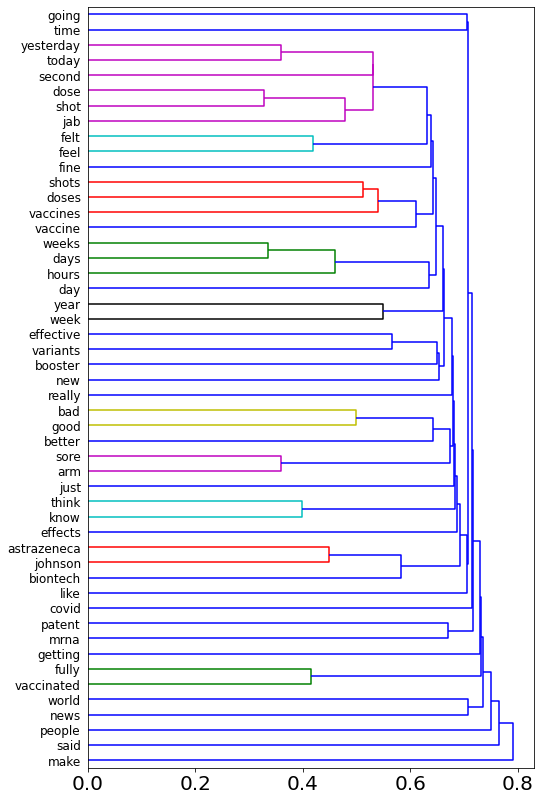

In [142]:
from sklearn.metrics.pairwise import cosine_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

top_terms = list(frequent_corpus.get_term_freq_df().sum(axis=1).sort_values(ascending=False).iloc[:50].index)
print('Top 25 terms')
print(top_terms)
mat = np.array([model.wv[t] for t in top_terms])
print('Embedding of "dose"')
print(model.wv['dose'])

def cosine_sim(a, b):
    return 1-np.dot(model.wv[a],model.wv[b])/(np.linalg.norm(model.wv[a])*np.linalg.norm(model.wv[b]))

print('Cosine distance of "dose" to "shot"', cosine_sim('dose', 'shot'))
print('Cosine distance of "dose" to "yesterday"', cosine_sim('dose', 'yesterday'))

print('Dimensions of term/embedding matrix:', mat.shape)


sim_mat = cosine_distances(mat)
print('Dimension of pairwise cosine distance of matrix:', sim_mat.shape)
plt.figure(figsize=(8,14))
dists = squareform(sim_mat)
linkage_matrix = linkage(dists, "single")
dendrogram(linkage_matrix, labels=top_terms, orientation='right', leaf_font_size=12.,)
plt.show()

### Side effect terms
- Let's take the words "sore" and "dizzy", and score words by how similar they are to the centroid of the two words
- This is called Latent Semantic Scaling
- The top ten most similar terms all releate to illnesses, and are thus plausible side effects

In [143]:
side_effect_df = pd.DataFrame({
    'SideEffect': st.latent_semantic_scale_from_word2vec(
        model, 
        pos_seed_words=['sore', 'dizzy']
    ),
    'Frequency': corpus.get_term_freq_df().sum(axis=1),
}).dropna().sort_values(by='SideEffect', ascending=False)
side_effect_df.head(10)

,SideEffect,Frequency
sore,1.373238,936.0
dizzy,1.373238,18.0
achey,1.271124,28.0
tired,1.230482,322.0
stiff,1.226114,15.0
queasy,1.221498,5.0
achy,1.212435,86.0
lethargic,1.211611,11.0
nauseous,1.164299,32.0
bruise,1.150194,10.0


## Plotting Side Effects
- Let's take the 500 words with the highest similarity score
- Plot their Cohen's d againt Moderna vs. Pfizer just as above
- Color them by how closely they are to the seed side effect words
- The lions share of the side effects occur with Moderna
- However, side effects around lymph nodes (especially in the armpits) and arthrits occured with Pfizer more than Moderna

In [144]:
side_effect_df = side_effect_df.iloc[:500]
side_effect_corpus = corpus.whitelist_terms(side_effect_df.index)
association_scores = st.CohensD(side_effect_corpus).set_categories('moderna').get_scores()

plot_df = side_effect_df.assign(
    SideEffectScaled = lambda df: st.Scalers.scale(df.SideEffect),
    Association = association_scores,
    X = lambda df: df.Frequency,
    Xpos = lambda df: st.Scalers.dense_rank(df.X),
    Y = lambda df: df.Association,
    Ypos = lambda df: st.Scalers.scale_center_zero_abs(df.Y)
).reindex(side_effect_corpus.get_terms())


html = st.dataframe_scattertext(
    side_effect_corpus,
    category_name='Moderna',
    not_category_name='Pfizer',
    plot_df=plot_df,
    metadata=get_heading(side_effect_corpus),
    ignore_categories=False,
    use_full_doc=True,
    x_label='Frequency',
    y_label="Cohen's d",
    y_axis_labels=['More Pfizer', 'Neutral', 'More Moderna'],
    color_score_column='SideEffectScaled',
    tooltip_columns=['Frequency', 'Association'],
    header_names={'upper': 'Top Moderna', 'lower': 'Top Pfzier', 'right': 'SideEfect'},
    left_list_column='Association',
    right_order_column='SideEffect',    
    d3_color_scale='d3.interpolateCool'

)
fn = 'side_effects.html'
open(fn, 'wb').write(('<h2>Side Effect Vaccine Association</h2>' + html).encode('utf-8'))
IFrame(src=fn, width = 1300, height=700)

